<div style="background-color:#05282c; padding:20px; text-align:center;">
    <h1 style="color:white;">MAKING OF LSTM MODEL FOR ARABIC FAKE NEWS DETECTION</h1>
       <h5 style="color:white;">A PART OF NLP 3 MODELs IMPLIMENTATION PROJECT</h5>
    
</div>


In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
fimport sklearn

2024-05-06 09:59:26.028297: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 09:59:26.028397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 09:59:26.156577: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<div style="background-color:#094a52; padding:20px;">
   <h1 style="font-size:24px;">DATA PREPROCESSING</h1>
</div>

<div style="background-color:#3b729a; padding:20px; text-align:center;">
       <h5 style="color:white;text-transform:uppercase;">READING DATA FRAMES stripping the text of ponctuations, links ,emojis and irrigular pattrens</h5>
</div>


In [8]:
df2 = pd.read_csv("/kaggle/input/clean-imad/cleaned_merged_data.csv")

In [44]:
# Read Arabic stop words from text file
with open("/kaggle/input/arabic/Arabic stop words .txt", encoding="utf-8") as file:
    arabic_stopwords = set(file.read().splitlines())

In [46]:
# Function to clean the text
def clean_text(text):
    # Remove links
    text = re.sub(r'http\S+', '', text)
    
    # Remove emojis and punctuations
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove specific patterns like ":\n\n1"
    text = re.sub(r':\n\n\d+', '', text)
    
    # Remove empty spaces
    text = text.strip()
    
    return text

# Clean the text column
df1['cleaned_text'] = df1['text'].apply(clean_text)


# Function to remove Arabic stop words
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in arabic_stopwords]
    return ' '.join(filtered_words)

# Remove Arabic stop words
df1['cleaned_text'] = df1['cleaned_text'].apply(remove_stopwords)

# Show the head of the DataFrame with cleaned text
print(df1[['text', 'cleaned_text']].head())


                                                text  \
0  يخوض المنتخب الوطني المغربي لكرة القدم لأقل من...   
1  ترأس عبد القادر اعمارة، وزير التجهيز و النقل و...   
2  أكد النجم الارجنتيني ليونيل ميسي أن فوز فريقه ...   
3  أكّد الدبلوماسي المغربي السابق بإسبانيا، عبد ا...   
4  أعلنت شركتا سانوفي الفرنسية العملاقة في تصنيع ...   

                                        cleaned_text  
0  يخوض المنتخب الوطني المغربي لكرة القدم لأقل 20...  
1  ترأس عبد القادر اعمارة وزير التجهيز النقل اللو...  
2  أكد النجم الارجنتيني ليونيل ميسي فوز فريقه برش...  
3  أكد الدبلوماسي المغربي بإسبانيا عبد الخالق أطر...  
4  أعلنت شركتا سانوفي الفرنسية العملاقة تصنيع الأ...  


<div style="background-color:#3b729a; padding:20px; text-align:center;">
       <h5 style="color:white;text-transform:uppercase;">stripping the text of ponctuations, links ,emojis and irrigular pattrens</h5>
</div>


In [14]:
# # Merge the dataframes on their titles
# merged_df = pd.merge(df1, df2, left_on='title', right_on='Title', how='left')

# # Select the required columns
# final_df = merged_df[['cleaned_text', 'label', 'Article_correction_cleaned']]
final_df = df2


In [20]:
# Display the final dataframe
final_df = final_df.drop(['Title','Topic','Origine','Article_date','Article_correction','Article_correction_cleaned'],axis =1)
final_df.head()

,Label,Article_content,Article_content_cleaned
0,real,القدس المحتلة- لن يتمكن المقدسي سامي درويش في ...,القدس المحتلة- لن يتمكن المقدسي سامي درويش في ...
1,real,طهران- منذ الهجوم الإسرائيلي على القنصلية الإي...,طهران- منذ الهجوم الإسرائيلي على القنصلية الإي...
2,real,غادر المحامي الفلسطيني راجي صوراني قطاع غزة رف...,غادر المحامي الفلسطيني راجي صوراني قطاع غزة رف...
3,real,نابلس- لليوم الثاني على التوالي، تتعرض قرية دو...,نابلس- لليوم الثاني على التوالي، تتعرض قرية دو...
4,real,بريتوريا- تقدمت اللجنة المستقلة للانتخابات في ...,بريتوريا- تقدمت اللجنة المستقلة للانتخابات في ...


In [21]:
final_df_shuffled = final_df.sample(frac=1).reset_index(drop=True)

In [57]:
final_df_shuffled.head()

,text,label,correction
0,كتب متابعات القاهرة واحدة أرخص مدن العالم لعيش...,real,NaN
1,الغنوشي لسعيد باب الحوار مفتوحا رئيس مجلس نواب...,real,NaN
2,أعلن معهد حلب لإعداد المدرسين الخميس إضراب مفت...,fake,NaN
3,وصلت وزيرة الخارجية والتعاون الدولي ليبيا نجلا...,real,NaN
4,استضافت مجموعة وشوشة الإعلامية الفنانة آيتن عا...,fake,NaN


In [58]:
#final_df_shuffled=final_df_shuffled.iloc[:30000]

In [22]:
# 'label' column contains the labels in the DataFrame
final_df_shuffled['Label'] = final_df_shuffled['Label'].map({'fake': 0, 'real': 1})

In [23]:
# Replace empty strings with NaN
final_df_shuffled['Label'].replace('', np.nan, inplace=True)

# Drop rows with NaN in the 'label' column
final_df_shuffled.dropna(subset=['Label'], inplace=True)

/tmp/ipykernel_34/1750402921.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df_shuffled['Label'].replace('', np.nan, inplace=True)


In [24]:
final_df_shuffled.drop(columns=['Article_content'], inplace=True)


In [62]:
final_df_shuffled.head()

,text,label
0,كتب متابعات القاهرة واحدة أرخص مدن العالم لعيش...,1
1,الغنوشي لسعيد باب الحوار مفتوحا رئيس مجلس نواب...,1
2,أعلن معهد حلب لإعداد المدرسين الخميس إضراب مفت...,0
3,وصلت وزيرة الخارجية والتعاون الدولي ليبيا نجلا...,1
4,استضافت مجموعة وشوشة الإعلامية الفنانة آيتن عا...,0


In [63]:
#final_df_shuffled=final_df_shuffled.iloc[:30000]

<div style="background-color:#094a52; padding:20px;">
   <h1 style="font-size:24px;">MAKING THE LSTM MODEL</h1>
</div>

In [25]:
# Data Preparation
X = final_df_shuffled['Article_content_cleaned']
y = final_df_shuffled['Label']

In [65]:
"""
# Remove Arabic stopwords
X = X.apply(lambda text: ' '.join([word for word in text.split() if word not in stop_words]))
"""

"\n# Remove Arabic stopwords\nX = X.apply(lambda text: ' '.join([word for word in text.split() if word not in stop_words]))\n"

<div style="background-color:#3b729a; padding:20px; text-align:center;">
       <h5 style="color:white;text-transform:uppercase;">initialisation of the hyper params </h5>
</div>


In [28]:
# Use LabelEncoder to convert labels to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [29]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [31]:
# Tokenization and Padding
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [32]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [33]:
max_sequence_length = 512   # Set an appropriate value
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

<div style="background-color:#3b729a; padding:20px; text-align:center;">
       <h5 style="color:white;text-transform:uppercase;">defining the LSTM layers + dense layers</h5>
</div>


In [46]:
# LSTM Model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.1)) #0.2

# Adding  LSTM layers
for _ in range(8):
    model.add((LSTM(units=64, return_sequences=True)))
model.add(Dense(units= 64, activation='relu'))
model.add(Dense(units= 64, activation='relu'))
model.add(Dense(units=len(np.unique(y_encoded)), activation='softmax'))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


* Compiliung the model

In [48]:
# Compile the Model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [49]:
# Print the Model Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

<div style="background-color:#3b729a; padding:20px; text-align:center;">
       <h5 style="color:white;text-transform:uppercase;">Running the model with plots every epoch</h5>
</div>


Default GPU Device: /device:GPU:0
Epoch 1/8
29/29 ━━━━━━━━━━━━━━━━━━━━ 32s 491ms/step - accuracy: 0.5666 - loss: 0.6761 - val_accuracy: 0.7092 - val_loss: 0.5313
Epoch 2/8
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 437ms/step - accuracy: 0.8141 - loss: 0.4376 - val_accuracy: 0.9314 - val_loss: 0.2216
Epoch 3/8
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 442ms/step - accuracy: 0.9629 - loss: 0.1513 - val_accuracy: 0.9651 - val_loss: 0.1208
Epoch 4/8
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 448ms/step - accuracy: 0.9838 - loss: 0.0672 - val_accuracy: 0.9728 - val_loss: 0.1092
Epoch 5/8
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - accuracy: 0.9901 - loss: 0.0468 - val_accuracy: 0.9749 - val_loss: 0.0993
Epoch 6/8
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 459ms/step - accuracy: 0.9951 - loss: 0.0281 - val_accuracy: 0.9760 - val_loss: 0.1081
Epoch 7/8
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 459ms/step - accuracy: 0.9967 - loss: 0.0211 - val_accuracy: 0.9717 - val_loss: 0.1132


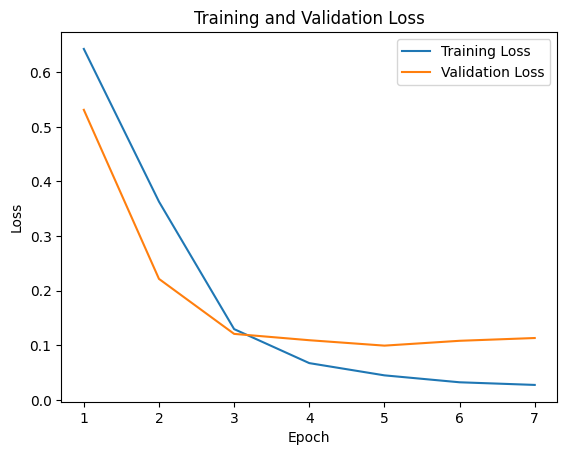

In [37]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU not found. Training on CPU.")

# Train the Model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Lists to store training and validation loss
train_loss = []
val_loss = []

# Ensure the model is using the GPU if available
with tf.device('/device:GPU:0'):
    history = model.fit(X_train_padded, y_train, epochs=8, validation_split=0.2, batch_size=128, shuffle=True, callbacks=[early_stop])
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

# Plotting
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

<div style="background-color:#3b729a; padding:20px; text-align:center;">
       <h5 style="color:white;text-transform:uppercase;">Evaluating the Model</h5>
</div>


In [38]:
# Evaluate the Model
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step
Test Accuracy: 0.9756


<div style="background-color:#3b729a; padding:20px; text-align:center;">
       <h5 style="color:white;text-transform:uppercase;">Repport + confusion Matrix</h5>
</div>


In [39]:
# Evaluate other metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       613
           1       0.98      0.97      0.97       534

    accuracy                           0.98      1147
   macro avg       0.98      0.98      0.98      1147
weighted avg       0.98      0.98      0.98      1147



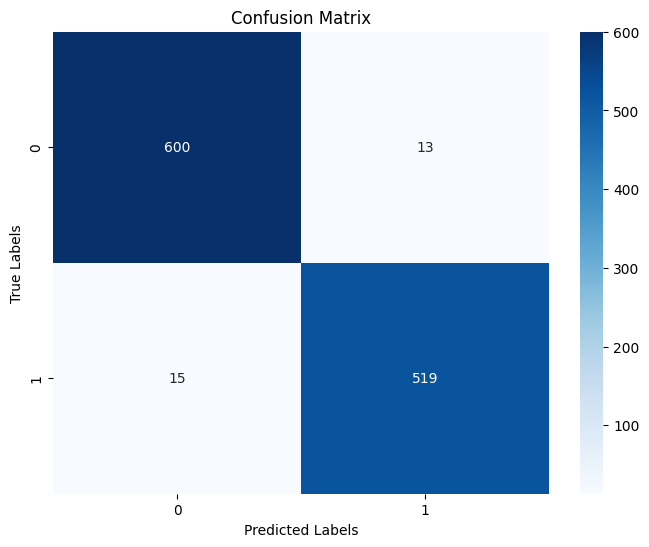

In [40]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

<div style="background-color:#3b729a; padding:20px; text-align:center;">
       <h5 style="color:white;text-transform:uppercase;">Saving the model in .h5 format</h5>
</div>


In [41]:
# Save the model
model.save('LSTM-ARABIC-FAKE-NEWS-DETECTION.h5')

ValueError: Unable to synchronously create dataset (name already exists)

<div style="background-color:#094a52; padding:20px;">
   <h1 style="font-size:24px;">PLOTS</h1>
</div>

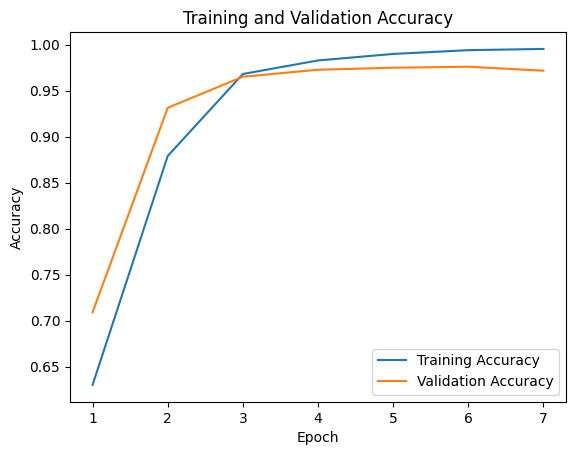

In [42]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

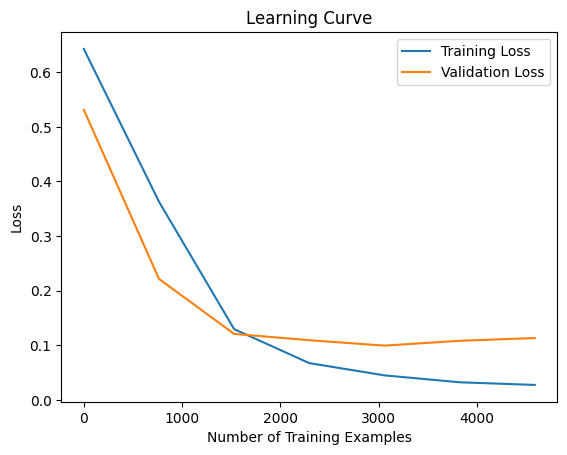

In [43]:
train_size = len(X_train_padded)
plt.plot(np.linspace(0, train_size, len(train_loss)), train_loss, label='Training Loss')
plt.plot(np.linspace(0, train_size, len(val_loss)), val_loss, label='Validation Loss')
plt.xlabel('Number of Training Examples')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


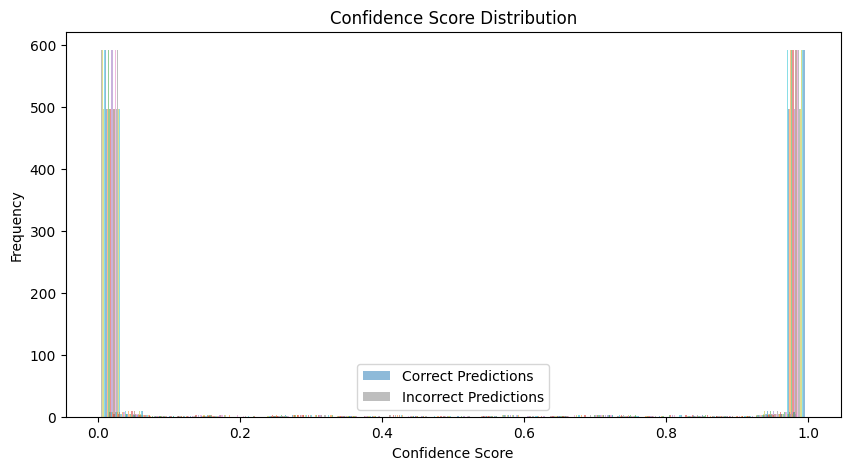

In [44]:
plt.figure(figsize=(10, 5))
plt.hist(y_pred_probs[np.where(y_test == y_pred)][:, y_pred], bins=30, alpha=0.5, label='Correct Predictions')
plt.hist(y_pred_probs[np.where(y_test != y_pred)][:, y_pred], bins=30, alpha=0.5, label='Incorrect Predictions')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Score Distribution')
plt.legend()
plt.show()
